<a href="https://colab.research.google.com/github/motoroko/Caterpillar-Pest-Detection-System-on-Agricultural-Plants/blob/main/Caterpillar_Pest_Detection_System_on_Agricultural_Plants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
from matplotlib import pyplot as plt #ploting Object
from matplotlib.image import imread #untuk membaca image/membaca image yang kita upload atua yang kita inginkan

import random #generate random number
import pandas as pd #pandas , dataframe
import numpy as np # numpy, module matematika pyhton
from numpy import load as np_load # untuk membaca file dengan format Numpy,  contoh .npy (numpy python)
from numpy import asarray, save #asarray untuk mengubah type dari variable menjadi numpy array, save untuk mensave data dengan format numpy

from sklearn.model_selection import GridSearchCV, train_test_split #gridsearchCV, module untuk mencari nilai parameter optimal yang dibutuhkan pada saat training data, train_test_split untuk men split dataset menjadi 4 array, input training, label training, input validasi, label validasi
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.vgg16 import VGG16
from keras.layers.core import Flatten, Dense
from keras.layers import Dropout
from keras.callbacks import CSVLogger

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from IPython.display import Image, display
from os import walk, rmdir, listdir #Os it Operating Systen. walk itu sama kaya looping for i, tapi khusus untuk diluar python, rmdir itu remove from directory, listdir - untuk membuat daftar nama file/folder yang ada di alamat yang kita masukan
from json import dump, load # json itu module dictionary, dump cara kerjanya sama kaya save, untuk save ke dalam file, load untuk mengambil data dari file ke dalem colab

import itertools #untuk membaca dictionary
import seaborn as sn #visualisasi heatmap

from google.colab.patches import cv2_imshow # Module dari google colab untuk bisa nampilin foto di output
import cv2 #opencv

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Model Training

## Dataset

In [ ]:
# define location of dataset
folder = '/content/drive/MyDrive/Dataset_Ulat1/'

## Plot Photos

Running the example creates a figure showing the first nine photos of the dataset.

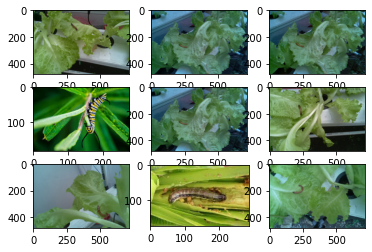

In [ ]:
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'caterpillar  (' + str(random.randint(0,2740)) + ').jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

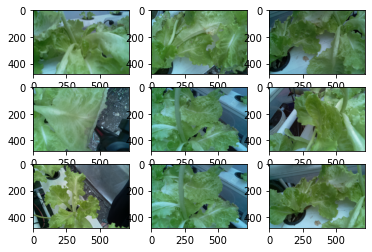

In [ ]:
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'without_caterpillar  (' + str(random.randint(0,2370)) + ').jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

##Select Standardized Photo Size
The photos will have to be reshaped prior to modeling so that all images have the same shape. This is often a small square image.

There are many ways to achieve this, although the most common is a simple resize operation that will stretch and deform the aspect ratio of each image and force it into the new shape.

We could load all photos and look at the distribution of the photo widths and heights, then design a new photo size that best reflects what we are most likely to see in practice.

Smaller inputs mean a model that is faster to train, and typically this concern dominates the choice of image size. In this case, we will follow this approach and choose a fixed size of 200×200 pixels.

In [ ]:
try:
  rmdir('/content/drive/MyDrive/Dataset_Ulat1/.ipynb_checkpoints')
except:
  pass

In [ ]:
# load dataset, reshape and save to a new file

try:
  # load and confirm the shape
  photos = asarray(np_load(folder + 'detection_caterpillar_photos.npy'))
  labels = asarray(np_load(folder + 'detection_caterpillar_labels.npy'))
  print(photos.shape, labels.shape)
except:
  photos, labels = list(), list()
  # enumerate files in the directory
  for file in listdir(folder):
    if file.startswith('without_caterpillar') or file.startswith('caterpillar'):
      # determine label class
      output = 0 if file.startswith('without_caterpillar') else 1
      # load image
      photo = load_img(folder + file, target_size=(128, 128))
      # convert to numpy array
      photo = img_to_array(photo)
      # store
      photos.append(photo)
      labels.append(output)

  # convert to a numpy arrays
  photos = asarray(photos)
  labels = asarray(labels)
  print(photos.shape, labels.shape)
  # save the reshaped photos
  save(folder + 'detection_caterpillar_photos.npy', photos)
  save(folder + 'detection_caterpillar_labels.npy', labels)

for i,name in enumerate(photos):
  photos[i] = cv2.cvtColor(photos[i], cv2.COLOR_BGR2RGB)
  photos[i] = cv2.GaussianBlur(photos[i],(3,3),cv2.BORDER_DEFAULT)

(5110, 128, 128, 3) (5110,)


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(photos,labels, test_size=0.25, random_state=0)
trainX.shape

(3832, 128, 128, 3)

##Develop a Baseline CNN Model


In [ ]:
def define_model(optimizer='Adam',learning_rate=0.001,dropout=.0,dropout_end=.1):
	# load model
  model = VGG16(include_top=False,input_shape=(128, 128, 3))

  # mark loaded layers as not trainable
  updated_model = Sequential()
  for layer in model.layers:
    layer.trainable = False
    updated_model.add(layer)
    if layer.name[-4:] == 'pool':
      updated_model.add(Dropout(dropout))

  model = updated_model

	# add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout = Dropout(dropout_end)(class1)
  output = Dense(1, activation='sigmoid')(dropout)

	# define new model
  model = Model(inputs=model.inputs, outputs=output)

  # compile model
  if  optimizer == 'Adam' :
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD' :
    optimizer = SGD(learning_rate=learning_rate)
  elif optimizer == 'RMSprop' :
    optimizer = RMSprop(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

## Grid Search Parameters

In [ ]:
try:
  with open(folder + 'kernels.json', 'r') as f:
    params = load(f)
    model_params = dict(itertools.islice(params.items(), 2,6,1))
    fit_params = dict(itertools.islice(params.items(), 2))
except:
  model = KerasClassifier(build_fn=define_model)
  parameters = {
    'batch_size': [8,16,32],
    'epochs': [5,10,20],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'dropout_end' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  }
  grid = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1)
  grid.fit(trainX, trainY)
  params = grid.best_params_
  model_params = dict(itertools.islice(params.items(), 2,6,1))
  fit_params = dict(itertools.islice(params.items(), 2))
  with open(folder + 'kernels.json', 'w') as f:
    dump(grid.best_params_, f)

## Train Model

In [ ]:
try:
  model = load_model(folder +'final_model.h5')
except:
  model = define_model(**model_params)
  csv_logger = CSVLogger(folder + 'training.log', separator=',', append=False)
  model.fit(trainX, trainY, validation_data=(testX,testY), callbacks=[csv_logger], **fit_params)
  model.save(folder + 'final_model.h5')

In [ ]:
train_loss, train_acc = model.evaluate(trainX,trainY)
test_loss, test_acc = model.evaluate(testX,testY)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


40/40 [==============================] - 7s 182ms/step - loss: 0.6421 - accuracy: 0.8920


## Summarized diagnostics Model

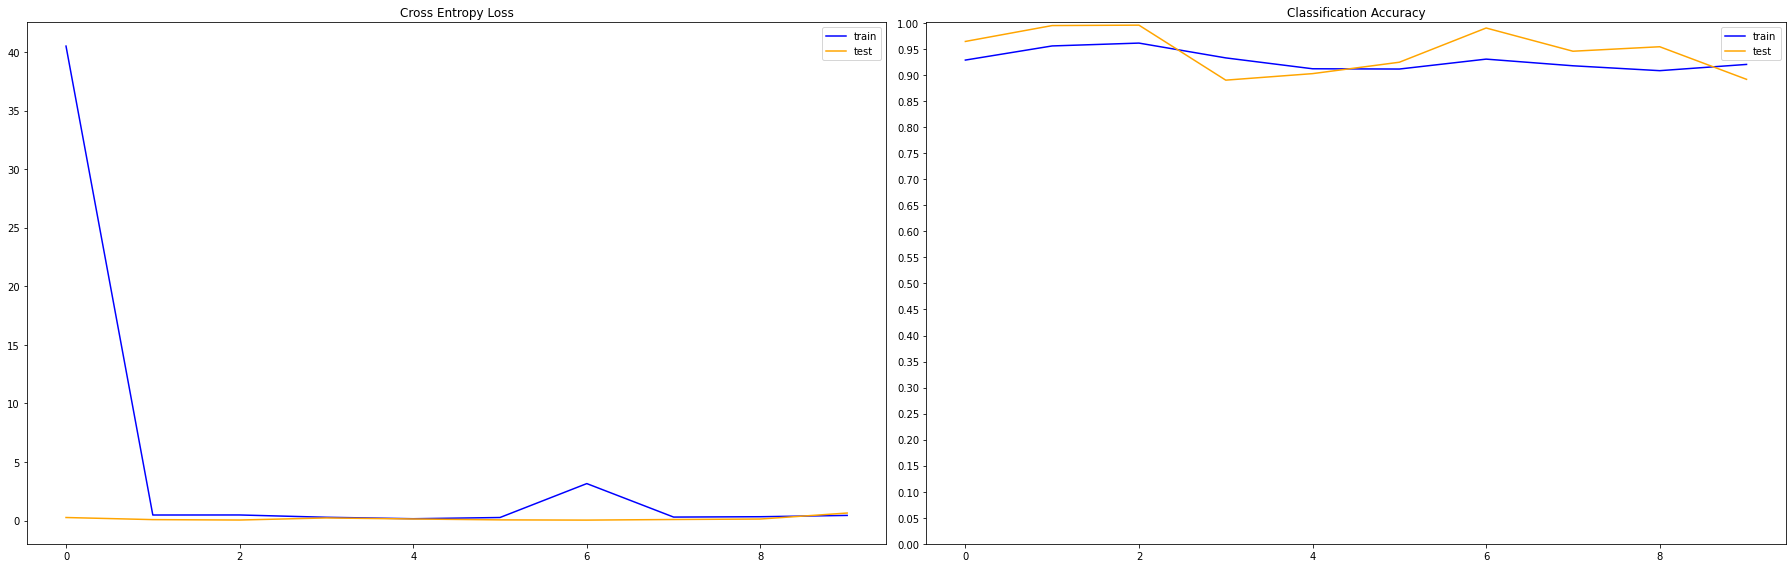

In [ ]:
def summarize_diagnostics(history):
  # plot loss
  fig = plt.figure(figsize=(25,8))
  plt.subplot(121)
  plt.title('Cross Entropy Loss')
  plt.plot(history['loss'], color='blue', label='train')
  plt.plot(history['val_loss'], color='orange', label='test')
  #plt.yticks(np.arange(0,0.4,0.05))
  plt.legend()
  # plot accuracy
  plt.subplot(122)
  plt.title('Classification Accuracy')
  plt.plot(history['accuracy'], color='blue', label='train')
  plt.plot(history['val_accuracy'], color='orange', label='test')
  plt.yticks(np.arange(0.,1.05,0.05))
  plt.legend()
  # save plot to file
  plt.tight_layout()
  plt.show()

log_data = pd.read_csv(folder + 'training.log', sep=',', engine='python')
summarize_diagnostics(log_data)

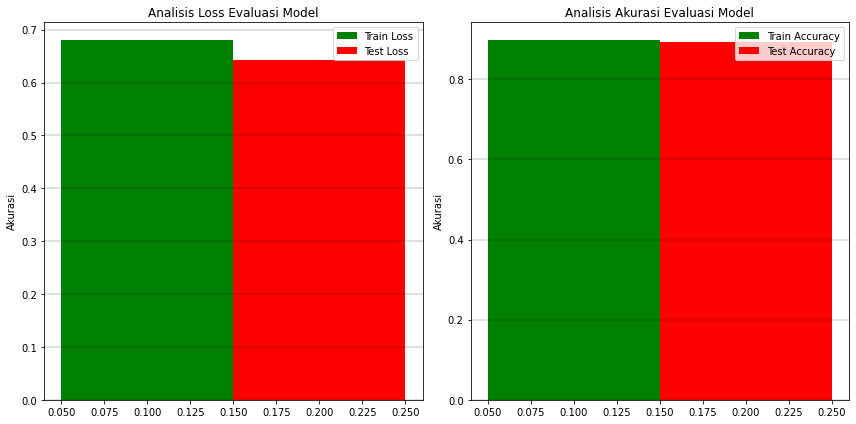

In [ ]:
ind = 0
width = 0.1

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.bar(ind + 0.1, train_loss, width, color='g',label='Train Loss')
plt.bar(ind + 0.2, test_loss, width, color='r',label='Test Loss')

plt.ylabel('Akurasi')
plt.title('Analisis Loss Evaluasi Model')
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
plt.legend(labels=['Train Loss','Test Loss'])

plt.subplot(122)
plt.bar(ind + 0.1, train_acc, width, color='g',label='Train Accuracy')
plt.bar(ind + 0.2, test_acc, width, color='r',label='Test Accuracy')

plt.ylabel('Akurasi')
plt.title('Analisis Akurasi Evaluasi Model')
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
plt.legend(labels=['Train Accuracy','Test Accuracy'])

plt.tight_layout()
plt.show()

## Validation predict

In [ ]:
try:
  predictions = model.predict(testX, **fit_params)
except:
  predictions = model.predict(testX)

for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(1278, 1)

## Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[460, 138],
       [  0, 680]])

## Classification Report

In [ ]:
target_names = ['without_caterpillar','caterpillar']

print(classification_report(testY,predictions,target_names=target_names))

                     precision    recall  f1-score   support

without_caterpillar       1.00      0.77      0.87       598
        caterpillar       0.83      1.00      0.91       680

           accuracy                           0.89      1278
          macro avg       0.92      0.88      0.89      1278
       weighted avg       0.91      0.89      0.89      1278



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
print('Accuracy : %.5f' % acc)

Accuracy : 0.89202


## Heatmap of validation result

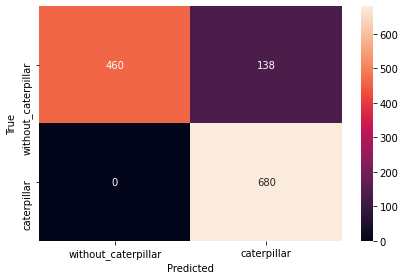

In [ ]:
x_axis_labels = ['without_caterpillar','caterpillar']
y_axis_labels = ['without_caterpillar','caterpillar']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Main Program

## Load Model

In [ ]:
# Load Model
model = load_model(folder + 'final_model.h5')

## Image From Files.Upload()

In [ ]:
# Image From Files.Upload()
from google.colab import files
src = files.upload()
for i,name in enumerate(src):
  src = name
photos = list()
image = load_img(src, target_size=(128, 128))
image = img_to_array(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
photos.append(image)
photos = asarray(photos)
predict = model.predict(photos)
cv2_imshow(image)

if predict >= 0.5:
  print('Hasil Prediksi Image',src,': \n>> ULAT TERDETEKSI <<')
else:
  print('Hasil Prediksi Image',src,': \n>> TIDAK ADA ULAT TERDETEKSI <<')

print('\n---------------------------------------------------------------------------------------------------------\n')

TypeError: ignored

## Image From GDrive

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


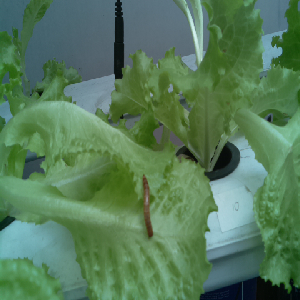

Prediction Value : 100.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/caterpillar  (906).jpg : 
>> ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



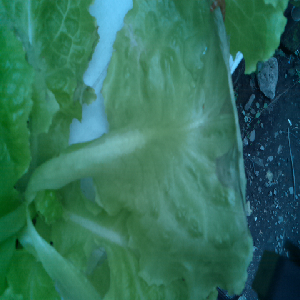

Prediction Value : 100.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/caterpillar  (329).jpg : 
>> ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



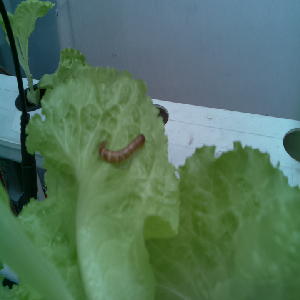

Prediction Value : 100.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/caterpillar  (1405).jpg : 
>> ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



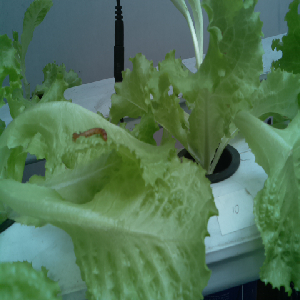

Prediction Value : 100.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/caterpillar  (934).jpg : 
>> ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



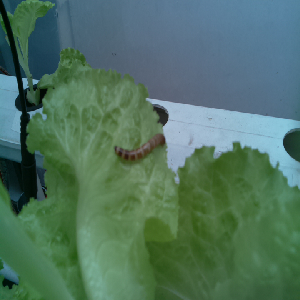

Prediction Value : 100.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/caterpillar  (1437).jpg : 
>> ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



In [ ]:
for i in range(5):
  photos = list()
  src = folder + 'caterpillar  (' + str(random.randint(0,2360)) + ').jpg'
  image = load_img(src, target_size=(128, 128))
  image = img_to_array(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  photos.append(image)
  photos = asarray(photos)
  predict = model.predict(photos)

  cv2_imshow(cv2.cvtColor(img_to_array(load_img(src, target_size=(300, 300))), cv2.COLOR_BGR2RGB))
  if predict >= 0.5:
    print('Prediction Value :',predict[0][0]*100,'%')
    print('Hasil Prediksi Image',src,': \n>> ULAT TERDETEKSI <<')
    pass
  else:
    print('Prediction Value :',predict[0][0]*100,'%')
    print('Hasil Prediksi Image',src,': \n>> TIDAK ADA ULAT TERDETEKSI <<')

  print('\n---------------------------------------------------------------------------------------------------------\n')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


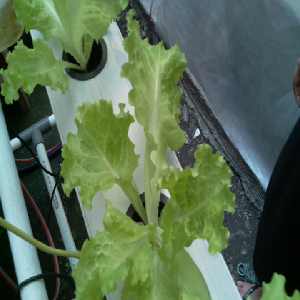

Prediction Value : 0.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/without_caterpillar  (2352).jpg : 
>> TIDAK ADA ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



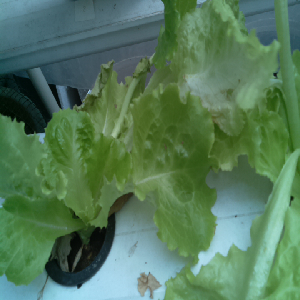

Prediction Value : 0.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/without_caterpillar  (269).jpg : 
>> TIDAK ADA ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



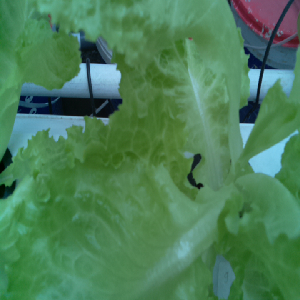

Prediction Value : 77.22094655036926 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/without_caterpillar  (2085).jpg : 
>> ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



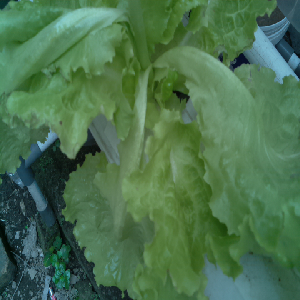

Prediction Value : 0.0 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/without_caterpillar  (1152).jpg : 
>> TIDAK ADA ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



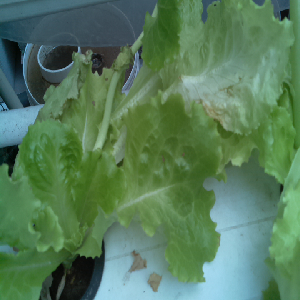

Prediction Value : 77.22094655036926 %
Hasil Prediksi Image /content/drive/MyDrive/Dataset_Ulat1/without_caterpillar  (636).jpg : 
>> ULAT TERDETEKSI <<

---------------------------------------------------------------------------------------------------------



In [ ]:
for i in range(5):
  photos = list()
  src = folder + 'without_caterpillar  (' + str(random.randint(0,2360)) + ').jpg'
  image = load_img(src, target_size=(128, 128))
  image = img_to_array(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  photos.append(image)
  photos = asarray(photos)
  predict = model.predict(photos)

  cv2_imshow(cv2.cvtColor(img_to_array(load_img(src, target_size=(300, 300))), cv2.COLOR_BGR2RGB))
  if predict >= 0.5:
    print('Prediction Value :',predict[0][0]*100,'%')
    print('Hasil Prediksi Image',src,': \n>> ULAT TERDETEKSI <<')
  else:
    print('Prediction Value :',predict[0][0]*100,'%')
    print('Hasil Prediksi Image',src,': \n>> TIDAK ADA ULAT TERDETEKSI <<')

  print('\n---------------------------------------------------------------------------------------------------------\n')